# Evaluating ability to account for other machines

Notebook to investigate the ability to use predictions from the CNN and to feed them into a secondary model to predict other machine pull times.

In [1]:
import os
import time

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.data.config import load_config
from optpresso.data.partition import find_test_paths
from optpresso.models.serialization import load_model

from IPython.core.display import display

In [2]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Path to alternative machine data
DATA_DIR = os.path.expanduser("~/breville/")
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv&gid=1013114014"
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
config = load_config()
if config is None:
    print("Invalid config, call optpresso init")
    raise ValueError("Invalid config")
model_path = config.model
model = load_model(model_path, compile=False)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)
for key in images_by_time.keys():
    images_by_time[key].sort()

2021-12-31 17:26:28.990051: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-31 17:26:28.990075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: badisa-System-Product-Name
2021-12-31 17:26:28.990079: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: badisa-System-Product-Name
2021-12-31 17:26:28.990134: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.56.0
2021-12-31 17:26:28.990148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.56.0
2021-12-31 17:26:28.990152: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.56.0
2021-12-31 17:26:28.990340: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to us

In [3]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')

### A bit of hacky code to associate CSV data with the relevant file paths

Relies on the fact that there are gaps in time between each set of images. Helped by the data is consistently
collected in this case, the training data doesn't work with the same procedure.

In [4]:

def cluster(clusters: int, paths: List[str]) -> Tuple[List[str], List[str]]:
    timestamps = np.zeros(len(paths), dtype=np.int32)
    deltas = np.zeros(len(paths) - 1, dtype=np.int32)
    for i, path in enumerate(paths):
        pull_time = int(os.path.basename(os.path.dirname(path)))
        timestamp = os.path.basename(path).split("-")[0]
        if not timestamp.isdigit():
            raise RuntimeError(f"{path} doesn't start with timestamp!")
        timestamps[i] = int(timestamp)
        if i > 0:
            deltas[i-1] = np.abs(timestamps[i-1] - timestamps[i])
    sort = np.argsort(deltas)[::-1] # Descending order
    # Get one less indice to split, to create N chunks
    indices_to_split = sort[:clusters-1].tolist()
    idx = 0
    cluster_groups = []
    for i in range(len(paths)):
        if i == 0:
            cluster_groups.append(idx)
            continue
        if i - 1 in indices_to_split:
            idx += 1
        cluster_groups.append(idx)
        
    return np.asarray(cluster_groups, dtype=np.int32)

all_paths = []
for pull, paths in images_by_time.items():
    all_paths.extend(paths)
clustered = cluster(len(df), all_paths)
chunks = defaultdict(list)
for pull, paths in images_by_time.items():
    sub_df = df[df.timeseconds == pull]
    last_time = None
    groups = cluster(len(sub_df), paths)
    for group in set(groups):
        relevant_paths = [x for x in np.where(groups == group, paths, None) if x is not None]
        series_time = None
        for path in relevant_paths:
            pull_time = os.path.basename(os.path.dirname(path))
            if not pull_time.isdigit():
                raise ValueError("Invalid {}".format(relevant_paths))
            pull_time = int(pull_time)
            if series_time is None:
                series_time = pull_time
            elif series_time != pull_time:
                raise ValueError("Got multiple pull times! {}".format(relevant_paths))
        chunks[series_time].append(relevant_paths)

last_index_per_time = defaultdict(int)
predictions = []
for row in df.values:
    pull_time = row[2]
    chunk_idx = last_index_per_time[pull_time]
    loader = GroundsLoader(min(256, len(chunks[pull_time][chunk_idx])), (model.input_shape[1], model.input_shape[2]), paths=chunks[pull_time][chunk_idx])
    predictions.append(np.median(model.predict(loader.get_batch(0, len(loader))[0]).squeeze()))
    last_index_per_time[pull_time] += 1
for pull, idx in last_index_per_time.items():
    if len(chunks[pull]) != idx:
        raise ValueError(f"Didn't consume all chunks: {pull} has {len(chunks[pull])}, and only used {idx}")
df["predictions"] = predictions

2021-12-31 17:26:30.115938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-31 17:26:34.082031: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 275251200 exceeds 10% of free system memory.
2021-12-31 17:26:34.138490: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 275251200 exceeds 10% of free system memory.
2021-12-31 17:26:38.312127: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206438400 exceeds 10% of free system memory.
2021-12-31 17:26:38.352879: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 206438400 exceeds 10% of free system memory.
2021-12-31 17:26:38.872892: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 235929600 exceeds 10% of free system memory.


In [5]:
df = df[df["grinder"] != "Vario-W"] # Need to munge the grind settings into a series
df = df.astype({'grindsetting': 'float32'})

In [6]:
# Do an 80:20 cross validation split
train = df.sample(frac=0.7, random_state=618)
test = df.drop(train.index)

In [7]:
test

,ingrams,outgrams,timeseconds,coffee,grinder,machine,grindsetting,ratio,predictions
7,15.3,54.6,22,Candlestick - Columbia,Breville,Breville Barista Express,5.0,3.57,12.180346
10,15.2,54.6,22,Candlestick - Columbia,Breville,Breville Barista Express,6.0,3.59,15.166845
13,15.6,55.2,21,Candlestick - Columbia,Breville,Breville Barista Express,7.0,3.54,13.371173
15,13.3,57.3,18,Candlestick - Columbia,Breville,Breville Barista Express,8.0,4.31,10.670370
21,19.4,55.7,22,Candlestick - Columbia,Breville,Breville Barista Express,10.0,2.87,12.154268
25,18.0,41.2,23,City of Saints - Decaf columbia,Niche Zero,Illy Francis Francis,10.0,2.29,40.572254
26,16.0,42.3,25,Brandywine - Colombia Monteblanco Purple Catur...,Niche Zero,Illy Francis Francis,7.0,2.64,35.873898
29,13.4,41.9,23,Facsimile - El Mirador Columbia,Niche Zero,Illy Francis Francis,7.0,3.13,40.113773
31,16.0,35.7,29,Candlestick - Columbia,Niche Zero,Illy Francis Francis,7.0,2.23,42.636421
32,17.0,38.2,32,Candlestick - Columbia,Niche Zero,Illy Francis Francis,7.0,2.25,48.420830


## Evaluate using Gaussian Process to make predictions

It is feasible to build a personalized Gaussian Process (GP) model, and this is to do a basic proof of concept to see if it isn't totally worthless.

In [8]:
def prepare_df_for_gp(frame, prediction_column="timeseconds", encoders={}, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        try:
            new_frame = new_frame.drop([col], axis=1)
        except KeyError:
            continue
    for col, encoder in encoders.items():
        if col not in new_frame:
            print("No such column:", col)
            continue
        vals = encoder.transform(np.asarray(new_frame[col]).reshape(-1, 1))
        
        new_frame[col] = [vals[i] for i in range(len(vals))] 
        
    
    y = np.asarray(new_frame[prediction_column])
    for drop_col in [prediction_column, "arbitraryrating1-10", "tdsatagounfiltered", "date", "details", "timeprediction"]:
        try:
            new_frame = new_frame.drop(drop_col, axis=1)
        except KeyError:
            continue
    cols = list(sorted(new_frame.columns.tolist()))
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    frame_array = new_frame[cols].to_numpy()
    x = np.zeros((frame_array.shape[0], np.hstack(frame_array[0]).shape[0]))
    # Surely there is a way to vectorize this?
    for i in range(frame_array.shape[0]):
        x[i] = np.hstack(frame_array[i])
    
    return x, y

In [9]:
encoded_cols = ("grinder", "coffee", "machine")
encs = {}
for col in encoded_cols:
    if col not in df:
        print("No such column to encode", col)
        continue
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
    encoder.fit(np.asarray(df[col]).reshape(-1, 1))
    encs[col] = encoder

With Dropped columns: ['ratio']


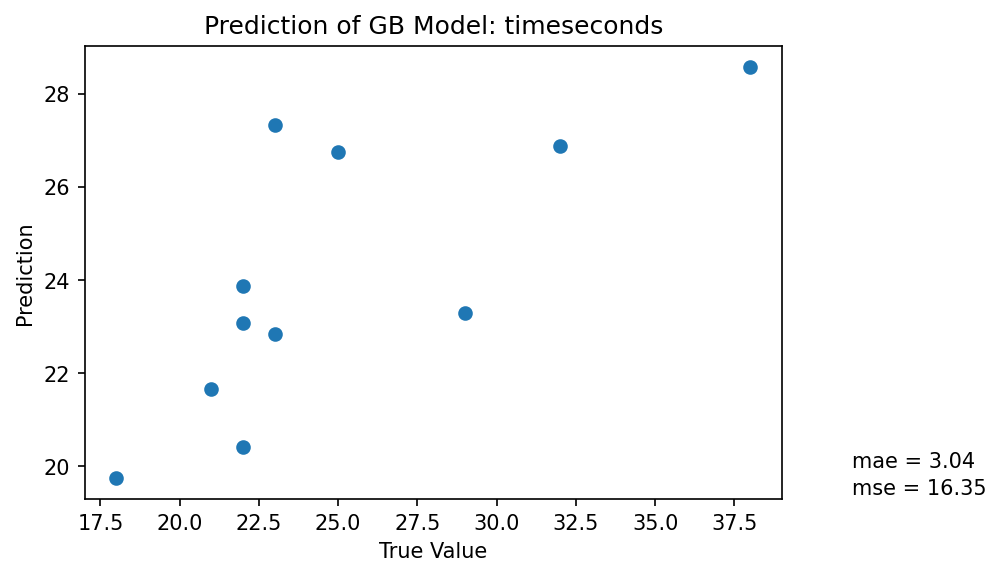

With Dropped columns: ('outgrams',)


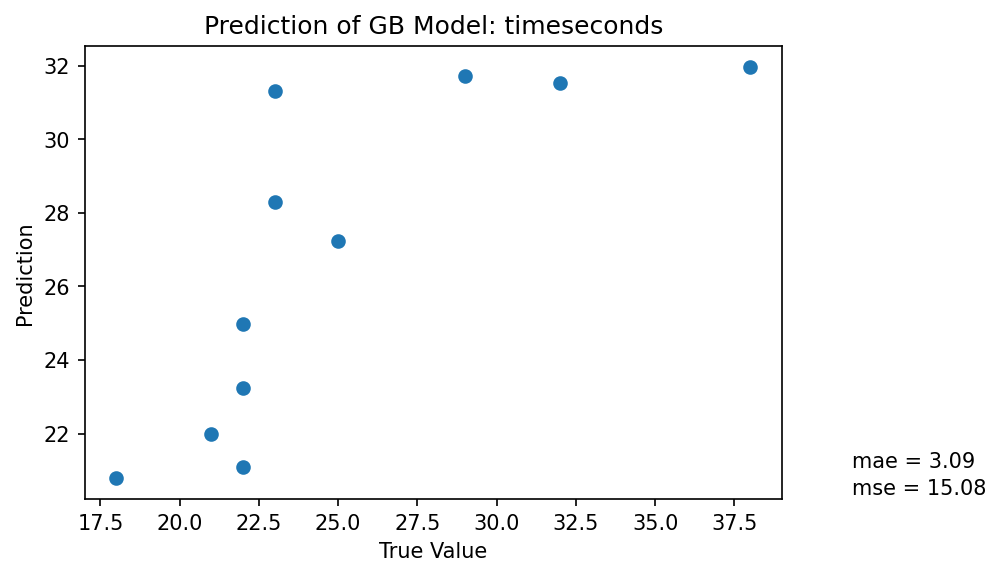

With Dropped columns: ('predictions',)


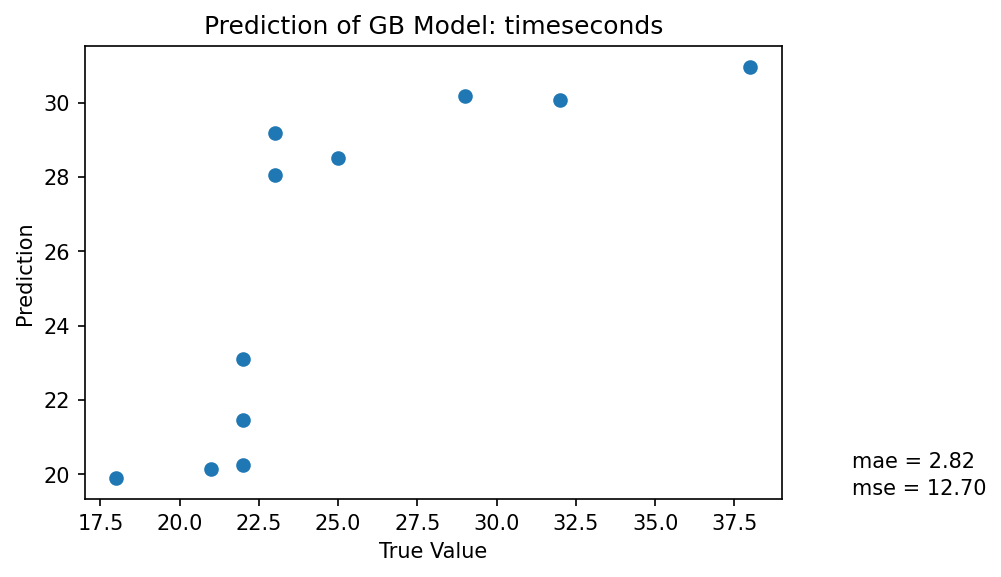

With Dropped columns: ('ratio', 'outgrams')


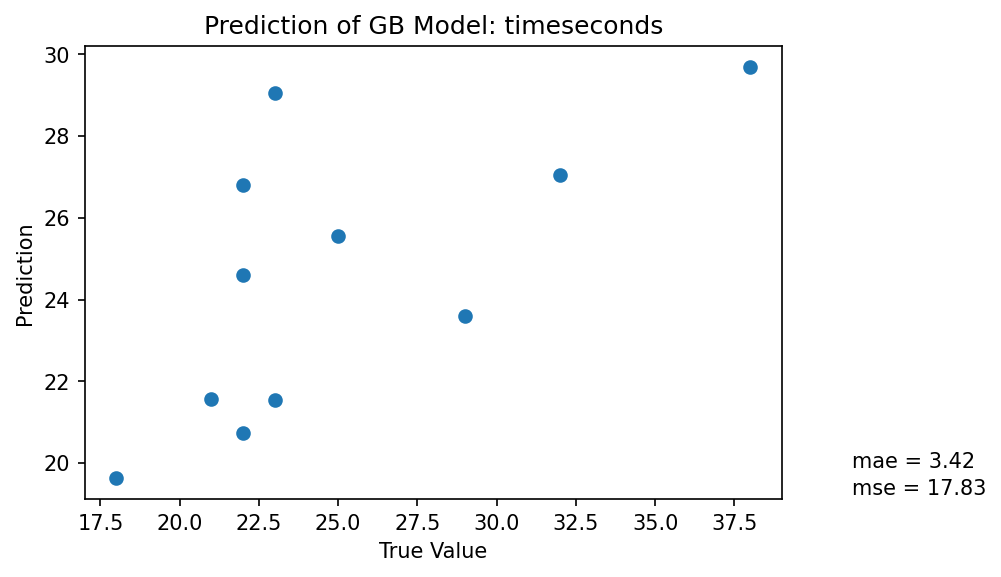

With Dropped columns: ('outgrams', 'predictions')


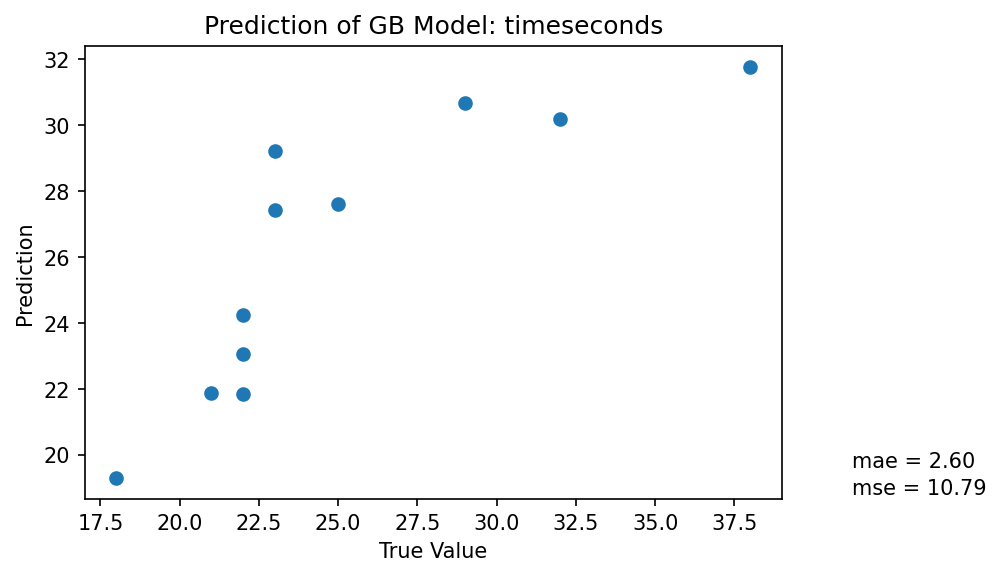

With Dropped columns: ['ratio']


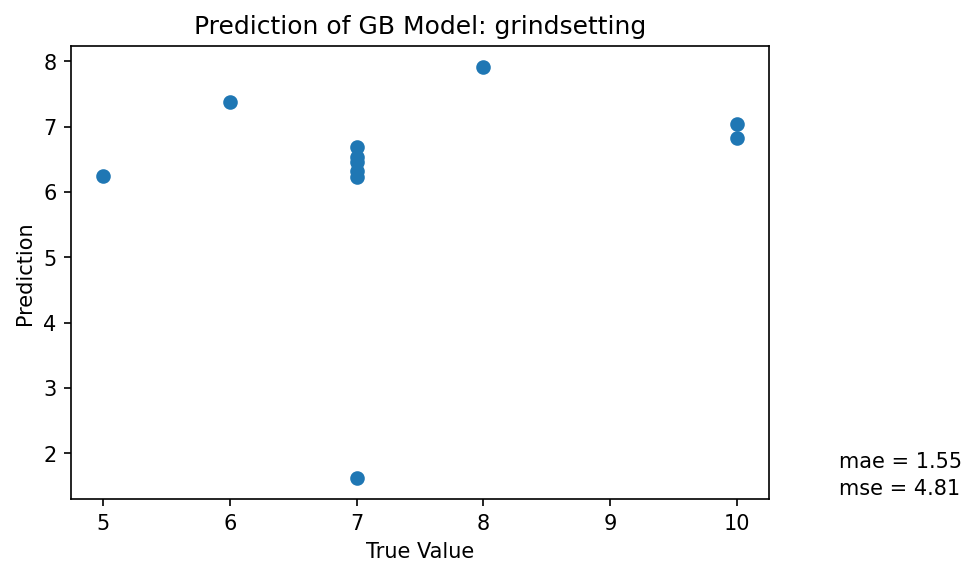

With Dropped columns: ('outgrams',)


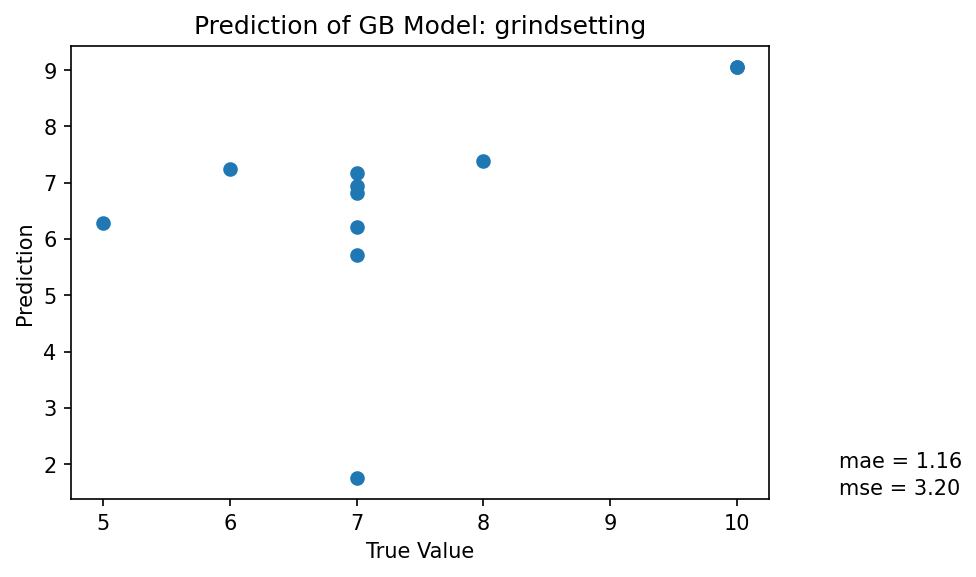

With Dropped columns: ('predictions',)


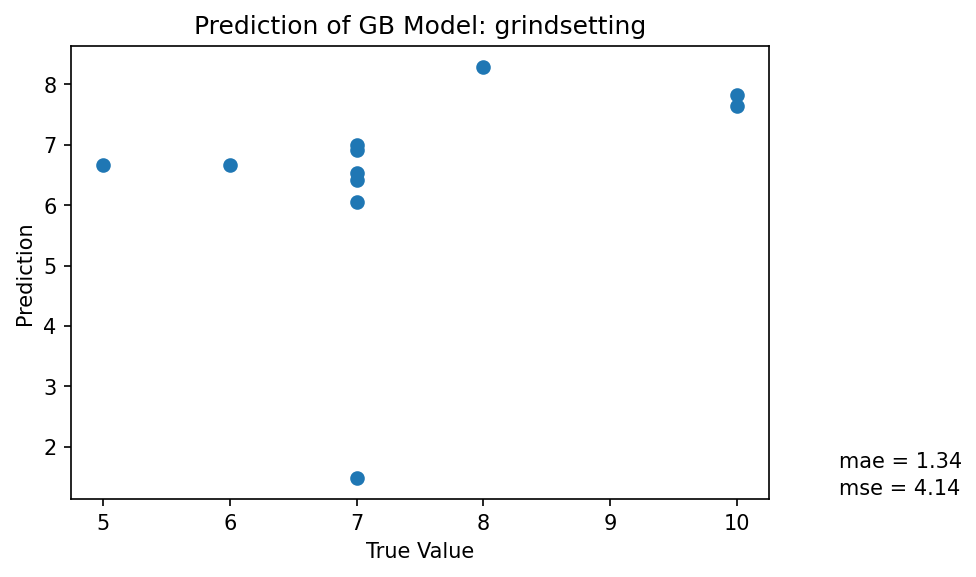

With Dropped columns: ('ratio', 'outgrams')


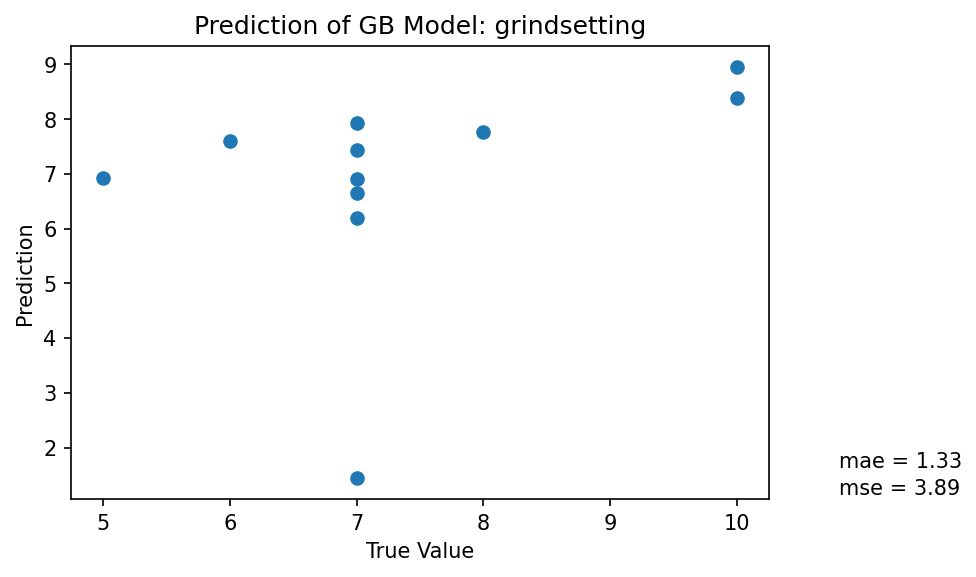

With Dropped columns: ('outgrams', 'predictions')


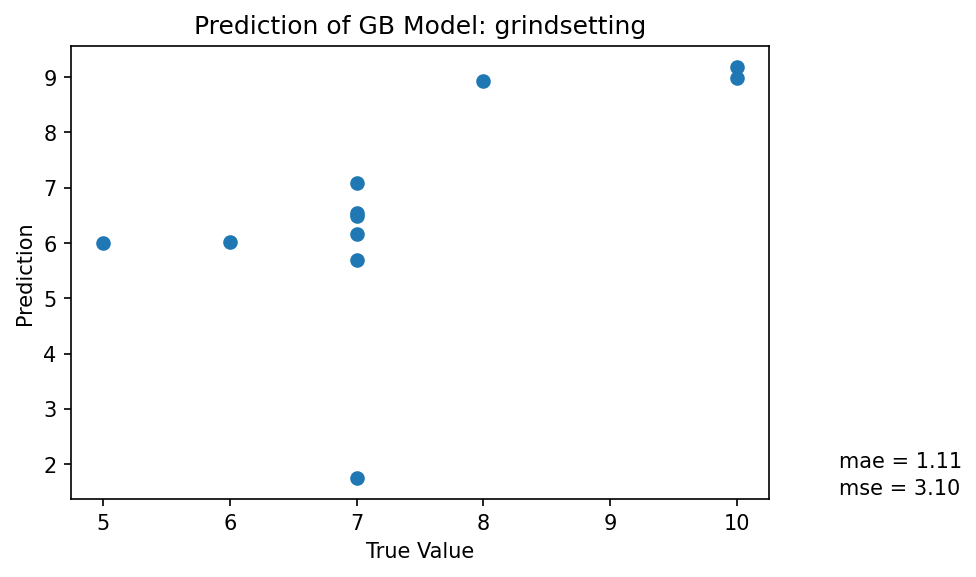

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
all_columns = set(train.columns.unique())
best_model_columns = None
for pred_field in ["timeseconds", "grindsetting"]:
    for dropped in [["ratio"], ("outgrams",), ("predictions",), ("ratio", "outgrams"), ("outgrams", "predictions")]:
        print("With Dropped columns:", dropped)
        x, y = prepare_df_for_gp(train, prediction_column=pred_field, drop_cols=dropped, encoders=encs)
        gp = GradientBoostingRegressor(n_estimators=1700)
        gp.fit(x, y)
        x_val, y_val = prepare_df_for_gp(test, prediction_column=pred_field, drop_cols=dropped, encoders=encs)
        yfit = gp.predict(x_val)
        fig = plt.figure(dpi=150)
        ax = fig.add_subplot(111)
        ax.set_title(f"Prediction of GB Model: {pred_field}")
        ax.set_xlabel("True Value")
        ax.set_ylabel("Prediction")
        ax.scatter(y_val, yfit)
        ax.annotate(
            "mse = {:.2f}".format(mean_squared_error(y_val, yfit)),
            (1.1, 0.01),
            xycoords="axes fraction",
        )
        mse = mean_absolute_error(y_val, yfit)
        ax.annotate(
            "mae = {:.2f}".format(mse),
            (1.1, 0.07),
            xycoords="axes fraction",
        )
        plt.show()